In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

**Data Preprocessing**

In [30]:
batch_size = 2
embedding_size = 2

In [31]:
sentences = ["apple banana fruit", "banana orange fruit", "orange banana fruit",
             "dog cat animal", "cat monkey animal", "monkey dog animal"]

In [32]:
word_sequence = " ".join(sentences).split()
word_list = list(set(word_sequence))
word_dict = {w: i for i, w in enumerate(word_list)}
voc_size = len(word_dict)

In [33]:
# Make skip gram of one size window
skip_grams = []

for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
    for w in context:
        skip_grams.append([target, w])

In [43]:
skip_grams

[[2, 6],
 [2, 3],
 [3, 2],
 [3, 2],
 [2, 3],
 [2, 7],
 [7, 2],
 [7, 3],
 [3, 7],
 [3, 7],
 [7, 3],
 [7, 2],
 [2, 7],
 [2, 3],
 [3, 2],
 [3, 1],
 [1, 3],
 [1, 5],
 [5, 1],
 [5, 0],
 [0, 5],
 [0, 5],
 [5, 0],
 [5, 4],
 [4, 5],
 [4, 0],
 [0, 4],
 [0, 4],
 [4, 0],
 [4, 1],
 [1, 4],
 [1, 0]]

In [37]:
def random_batch():
    random_inputs = []
    random_labels = []
    
    # np.random.choice(目标数组，选出数字个数（组成新的数组），replace=True表示可以重复选取)
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)
    
    for i in random_index:
        # np.eye(输出行数，输出列数，k默认为0表示的是主对角线，负数表示的是低对角，正数表示的是高对角) 输出一个对角矩阵
        #比如voc_size=8，经过np.eye(voc_size)就全部把它们变成了one-hot向量，再根据[skip_grams[i][0]取到目标那一行的one-hot
        random_inputs.append(np.eye(voc_size)[skip_grams[i][0]]) # target
        random_labels.append(skip_grams[i][1]) # context word
        
    return random_inputs, random_labels

In [45]:
random_index = np.random.choice(range(len(skip_grams)), 2, replace=False)
random_index

array([24, 12])

In [46]:
len(skip_grams)

32

In [49]:
random1 = random_batch()

In [51]:
random1

([array([0., 0., 0., 0., 1., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0.])],
 [1, 5])

**Model Building**

In [38]:
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        # W and WT is not Traspose relationship
        self.W = nn.Linear(voc_size, embedding_size, bias=False)  # voc_size -> embedding_size Weight
        self.WT = nn.Linear(embedding_size, voc_size, bias=False) # embedding_size -> voc_size Weight
        
    def forward(self, x):
        # x : [batch_size, voc_size]
        hidden_layer = self.W(x)             # hidden_layer : [batch_size, embedding_size]
        output_layer = self.WT(hidden_layer) # output_layer : [batch_size, voc_size]
        
        return output_layer
    

**Model Training**

In [55]:
model = Word2Vec()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5000):
    input_batch, target_batch = random_batch()
    input_batch = torch.Tensor(input_batch)
    target_batch = torch.LongTensor(target_batch)
    
    output = model(input_batch)
    
    optimizer.zero_grad()
    
    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    
    loss.backward()
    optimizer.step()
    
    if(epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
        

Epoch: 1000 cost = 1.794645
Epoch: 2000 cost = 1.641836
Epoch: 3000 cost = 1.421382
Epoch: 4000 cost = 2.028610
Epoch: 5000 cost = 1.228620


In [67]:
output

tensor([[ 0.5872,  0.1500, -0.8972, -0.8947,  0.5136,  0.5221, -0.4647, -0.6569],
        [ 1.7541,  0.5640, -2.8004, -2.7043,  1.0914,  1.2890, -1.6384, -1.6801]],
       grad_fn=<MmBackward0>)

In [66]:
target_batch

tensor([0, 0])

In [65]:
input_batch

tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]])

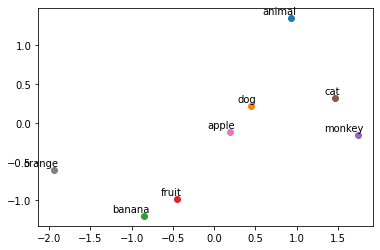

In [56]:
for i, label in enumerate(word_list):
    W, WT = model.parameters()
    x, y = W[0][i].item(), W[1][i].item()
    plt.scatter(x, y)
    # plt.annotate(要填入的文字，坐标点，填入文字相对于坐标点恶偏移位置， 提示是相对于坐标点偏移的， )
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom') 
plt.show()

In [64]:
W

Parameter containing:
tensor([[ 0.9335,  0.4454, -0.8462, -0.4500,  1.7433,  1.4675,  0.1941, -1.9444],
        [ 1.3431,  0.2143, -1.1992, -0.9770, -0.1623,  0.3213, -0.1212, -0.6047]],
       requires_grad=True)

In [59]:
WT

Parameter containing:
tensor([[ 1.0944,  0.4668],
        [ 0.4248, -0.1831],
        [-1.8221, -0.3986],
        [-1.7063, -0.6283],
        [ 0.4006,  1.5623],
        [ 0.6326,  1.1204],
        [-1.1794,  0.2831],
        [-0.8697, -1.2573]], requires_grad=True)

# The Seconed Part(more specific)

## Data Preprocessing

In [2]:
# import libraies
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize

### Using IMDB reviews as dataset

In [3]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

### Spliting the dataset

In [4]:
df = df['review'][:50]

In [4]:
df

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
5    Probably my all-time favorite movie, a story o...
6    I sure would like to see a resurrection of a u...
7    This show was an amazing, fresh & innovative i...
8    Encouraged by the positive comments about this...
9    If you like original gut wrenching laughter yo...
Name: review, dtype: object

In [5]:
text_all = []
for sen in df:
    text_all.append(sen)

In [6]:
text_all = ''.join(text_all)
text_all

'One of the other reviewers has mentioned that after watching just 1 Oz episode you\'ll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

In [7]:
import re
def text_preprocessing(text):
    text = re.sub(r'(@.*?)[\s]', ' ', text)             # 替换带有 @ 符号的用户名
    text = re.sub(r'[0-9]+' , '' ,text)                 # 删除所有数字（[0-9]+）
    text = re.sub(r'\s([@][\w_-]+)', '', text).strip()  # 替换带有 @ 符号的用户名
    text = re.sub(r'&amp;', ' ', text)                  # 替换所有 & 字符为 &
    text = re.sub(r'\s+', ' ', text).strip()            # 删除多余的空格（\s+） 
    text = re.sub('\[[^]]*\]', '', text)                # Removing the square brackets
    text = re.sub(r'<br /><br />', ' ', text)           # Rrmovine <br /><br />
    text = re.sub(r'[^a-zA-z0-9\s]', '', text)          # removing special characters
    text = text.replace("#" , " ")                      # 用空格替换 # 符号   
    encoded_string = text.encode("ascii", "ignore")     # 将文本编码为 ASCII，忽略不能编码的字符
    decode_string = encoded_string.decode()
    return decode_string

In [24]:
print('Original sentence:' , df[3],"\n")
print('Processed Sentence :' , text_preprocessing(df[3]))

Original sentence: Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them. 

Processed Sentence : Basically theres a family where a little boy Jake thinks theres a zombie in his closet  his parents are fighting all the time This movie is slower than a soap opera and suddenly Jake decides to become Rambo an

### Text stemming

In [8]:
text = text_preprocessing(text_all)

In [9]:
# 构造词典，统计每个词的频率，并根据频率将每个词转换为一个整数id
def build_dict(corpus):
    # 首先统计每个不同词的频率（出现的次数），使用一个词典记录
    word_freq_dict = dict()
    
    for word in corpus:
        if word not in word_freq_dict:
            word_freq_dict[word] = 0
        word_freq_dict[word] += 1
        
    # 将这个词典中的词，按照出现次数排序，出现次数越高，排序越靠前
    # 一般来说，出现频率高的高频词往往是：I，the，you这种代词，而出现频率低的词，往往是一些名词，如：nlp
    word_freq_dict = sorted(word_freq_dict.items(), key = lambda x:x[1], reverse = True)
    
    
    # 构造3个不同的词典，分别存储，
    # 每个词到id的映射关系：word2id_dict
    # 每个id出现的频率：word2id_freq
    # 每个id到词的映射关系：id2word_dict
    word2id_dict = dict()
    word2id_freq = dict()
    id2word_dict = dict()
    
    # 按照频率，从高到低，开始遍历每个单词，并为这个单词构造一个独一无二的id
    for word, freq in word_freq_dict:
        curr_id = len(word2id_dict)
        word2id_dict[word] = curr_id
        word2id_freq[word2id_dict[word]] = freq
        id2word_dict[curr_id] = word
        
    return word2id_freq, word2id_dict, id2word_dict

In [10]:
word2id_freq, word2id_dict, id2word_dict = build_dict(text.split())
vocab_size = len(word2id_freq)
print("there are totoally %d different words in the corpus" % vocab_size)
for _, (word, word_id) in zip(range(50), word2id_dict.items()):
    print("word %s, its id %d, its word freq %d" % (word, word_id, word2id_freq[word_id]))

there are totoally 3152 different words in the corpus
word the, its id 0, its word freq 591
word of, its id 1, its word freq 311
word a, its id 2, its word freq 302
word and, its id 3, its word freq 261
word to, its id 4, its word freq 250
word is, its id 5, its word freq 193
word in, its id 6, its word freq 166
word I, its id 7, its word freq 125
word it, its id 8, its word freq 116
word that, its id 9, its word freq 107
word this, its id 10, its word freq 99
word The, its id 11, its word freq 91
word movie, its id 12, its word freq 87
word with, its id 13, its word freq 84
word was, its id 14, its word freq 82
word for, its id 15, its word freq 73
word as, its id 16, its word freq 68
word but, its id 17, its word freq 65
word on, its id 18, its word freq 63
word film, its id 19, its word freq 63
word not, its id 20, its word freq 59
word are, its id 21, its word freq 56
word you, its id 22, its word freq 51
word one, its id 23, its word freq 50
word his, its id 24, its word freq 50
w

得到word2id词典后，还需要进一步处理原始语料，把每个词替换成对应的ID，便于神经网络进行处理

In [12]:
corpus = text.split()

In [13]:
# 把语料转换为id序列
def convert_corpus_to_id(corpus, word2id_dict):
    # 使用一个循环，将语料中的每个词替换成对应的id，以便于神经网络进行处理
    corpus = [word2id_dict[word] for word in corpus]
    return corpus

corpus = convert_corpus_to_id(corpus, word2id_dict)
print("%d tokens in the corpus" % len(corpus))
print(corpus[:50])

10673 tokens in the corpus
[214, 1, 0, 88, 1060, 46, 402, 9, 245, 160, 37, 304, 571, 1061, 29, 1062, 572, 21, 112, 16, 10, 5, 305, 47, 1063, 13, 43, 11, 66, 124, 9, 403, 43, 34, 304, 14, 26, 1064, 3, 1065, 113, 1, 161, 55, 306, 6, 112, 32, 0, 573]


### 二次采样
二次采样法的主要思想是降低高频词在语料中出现的频次。方法是随机将高频的词抛弃，频率越高，被抛弃的概率就越大；频率越低，被抛弃的概率就越小。标点符号或冠词这样的高频词就会被抛弃，从而优化整个词表的词向量训练效果。
文本数据中一般会出现一些高频词，如英文中的“the”“a”和“in”。通常来说，在一个背景窗口中，一个词（如“chip”）和较低频词（如“microprocessor”）同时出现比和较高频词（如“the”）同时出现对训练词嵌入模型更有益。因此，训练词嵌入模型时可以对词进行二次采样。 具体来说，数据集中每个被索引词Wi将有一定概率被丢弃，该丢弃概率为
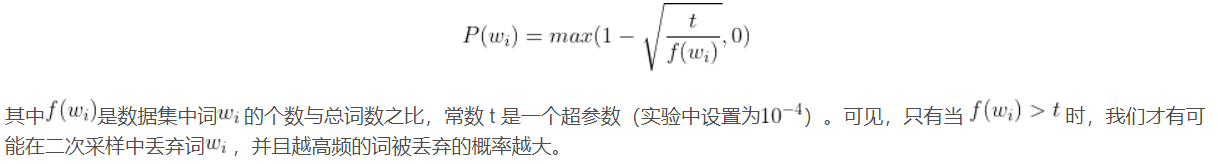

In [14]:
# 使用二次采样算法（subsampling）处理语料，强化训练效果
def subsampling(corpus, word2id_freq):
    
    # 这个discard函数决定了一个词会不会被替换，这个函数是具有随机性的，每次调用结果不同
    # 如果一个词的频率很大，那么它被遗弃的概率就很大
    def discard(word_id):
        # numpy.random.uniform(low=0.0, high=1.0, size=None)生出size个符合均分布的浮点数，取值范围为[low, high)，默认取值范围为[0, 1.0)
        return random.uniform(0, 1) < 1 - math.sqrt(1e-4 / word2id_freq[word_id] * len(corpus))
    """
    该函数的第一步是定义了一个嵌套函数 discard，它接受一个参数 word_id，并返回一个布尔值。

    discard 函数使用了一个随机数生成器，并将其与一个阈值进行比较。这个阈值是根据单词的频率计算出来的。如果随机数小于阈值，则 discard 返回 True，否则返回 False。

    然后，函数使用一个列表推导式来构建一个新的语料库。这个新的语料库只包含不被丢弃的单词。如果 discard(word) 返回 True，则丢弃该单词，否则将该单词加入新的语料库。

    最后，函数返回这个新的语料库。
    """
    corpus = [word for word in corpus if not discard(word)]
    
    return corpus

In [15]:
corpus = subsampling(corpus, word2id_freq)
print(f"There are {len(corpus)} tokens in the corpus")
print(corpus[:50])

There are 4523 tokens in the corpus
[214, 1060, 402, 245, 571, 1061, 29, 1062, 572, 1063, 11, 66, 1064, 1065, 161, 306, 32, 1066, 1067, 1068, 1069, 33, 1070, 1071, 53, 1072, 1073, 574, 575, 1074, 404, 573, 405, 1075, 1076, 576, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 577, 35, 1085, 1086, 406, 27]


在完成语料数据预处理之后，需要构造训练数据。根据上面的描述，我们需要使用一个滑动窗口对语料从左到右扫描，在每个窗口内，中心词需要预测它的上下文，并形成训练数据。

在实际操作中，由于词表往往很大（50000，100000等），对大词表的一些矩阵运算（如softmax）需要消耗巨大的资源，因此可以通过负采样的方式模拟softmax的结果。

* 给定一个中心词和一个需要预测的上下文词，把这个上下文词作为正样本。
* 通过词表随机采样的方式，选择若干个负样本。
* 把一个大规模分类问题转化为一个2分类问题，通过这种方式优化计算速度。

In [27]:
d = {
    ('apple', 3),
    ('banana',5),
    ('orange', 4)
}

for key, value in d:
    print(key, value)

apple 3
orange 4
banana 5


In [22]:
type(d)

dict